# Variance partitioning for the validation data

Here we will go head and analyze the explained variances in the validation data by using the previously identified significant microbes and SNPs as well as the fitted models.

In [1]:
from pyplink import PyPlink
import pandas as pd
import pickle
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
from rich.progress import track
import arivale_data_interface as adi
from utils import rsid2gene, summarize_associations
import warnings
warnings.simplefilter("ignore")

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEPRECATIONS = yaml.load(in_yaml)


We start by reading the actual data which includes the genotypes, CLR-transformed microbe abundances and metabolite abundances.

In [2]:
metabolites = pd.read_csv("data/valid.csv")
microbes = pd.read_csv("data/genera_clr_filtered.csv")
microbes = microbes[microbes.stool_sample_id.isin(metabolites.stool_sample_id)]
genotypes = PyPlink("input_bed/all_chr/all_genomes_09112019_all_chr")

We follow that by reading all the significant features we want to use.

In [3]:
sig_microbes = pd.read_csv("data/sig_metabolite_taxon.csv")
sig_snps = pd.read_csv("data/final_results.csv")
sig_snps["rsid"] = sig_snps.SNP.str.split(";").str[0]
genes = rsid2gene(sig_snps.rsid.unique())
sig_snps = sig_snps.merge(genes, left_on="rsid", right_on="snp", how="left")

This is all the data we need to calculate the R² values for the metabolites.

## Variances explained by the microbiome

We start by calculating the variances explained by the genus-level abundances.

In [4]:
micro_r2 = []
micro_fits = pickle.load(open("data/train_micro_fits.pkl", "rb"))
metabolites_and_microbes = pd.merge(metabolites, microbes, on="stool_sample_id")
for met in track(sig_microbes.metabolite.unique()):
    mics = sig_microbes.taxon[sig_microbes.metabolite == met]
    mterms = ["Q('%s')" % m for m in mics]
    mets = metabolites_and_microbes[met]
    formula = f"{met} ~ {' + '.join(mterms)}"
    fit = micro_fits[met]
    prediction = fit.predict(metabolites_and_microbes)
    fit = smf.ols("mets ~ predicted", data=pd.DataFrame({"mets": mets, "predicted": prediction})).fit()
    prediction = fit.predict(pd.DataFrame({"mets": mets, "predicted": prediction}))
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "micro_r2": 1.0 - (mets - prediction).var()/mets.var()
    }, index=[met])
    micro_r2.append(metrics)
micro_r2 = pd.concat(micro_r2)

Output()

In [5]:
micro_r2.micro_r2.describe()

count    7.050000e+02
mean     1.415587e-02
std      3.365582e-02
min      1.841063e-07
25%      7.420955e-04
50%      3.157943e-03
75%      1.111527e-02
max      3.599160e-01
Name: micro_r2, dtype: float64

## Variances explained by the genotype

Now we will do the same thing for the genotypes. We will treat the allele groups as categorical variables with homozygous major allele as the reference group.

In [6]:
geno_r2 = []
geno_fits = pickle.load(open("data/train_geno_fits.pkl", "rb"))
genome_ids = genotypes.get_fam().iid.values
for met in track(sig_snps.metabolite.unique()):
    snps = sig_snps.SNP[sig_snps.metabolite == met] #.str.split(";").str[0]
    snp_terms = ["Q('%s')" % s for s in snps]
    geno = pd.DataFrame({s: genotypes.get_geno_marker(s) for s in snps}, index=genome_ids)
    df = pd.merge(metabolites[["genome_id", met]], geno, left_on="genome_id", right_index=True)
    fit = geno_fits[met]
    prediction = fit.predict(df)
    mets = df[met]
    fit = smf.ols("mets ~ predicted", data=pd.DataFrame({"mets": mets, "predicted": prediction})).fit()
    prediction = fit.predict(pd.DataFrame({"mets": mets, "predicted": prediction}))
    metrics = pd.DataFrame({
        "metabolite": met,
        "geno_r2": 1.0 - (mets - prediction).var()/mets.var()
    }, index=[met])
    geno_r2.append(metrics)
geno_r2 = pd.concat(geno_r2)

Output()

In [7]:
geno_r2.geno_r2.describe()

count    1.820000e+02
mean     9.814454e-02
std      9.341189e-02
min      5.716994e-08
25%      3.960176e-02
50%      6.777448e-02
75%      1.297342e-01
max      4.990756e-01
Name: geno_r2, dtype: float64

## Track the partitioning

Now we will combine the datasets and also merge in the metabolite names.

In [8]:
metabolite_meta = adi.get_snapshot("metabolomics_metadata", clean=True) [["CHEMICAL_ID", "BIOCHEMICAL_NAME", "SUPER_PATHWAY", "SUB_PATHWAY", "CAS", "KEGG"]]
metabolite_meta["metabolite"] = "metabolite_" + metabolite_meta.CHEMICAL_ID.astype(str)
joint_r_sq = pd.merge(micro_r2, geno_r2, on="metabolite", how="outer")
joint_r_sq = pd.merge(joint_r_sq, metabolite_meta, on="metabolite")
joint_r_sq[["micro_r2", "geno_r2"]] = joint_r_sq[["micro_r2", "geno_r2"]].fillna(0)
joint_r_sq['total'] = joint_r_sq['micro_r2'] + joint_r_sq['geno_r2'] 
joint_r_sq = joint_r_sq.sort_values('total', ascending = False)

joint_r_sq

,metabolite,n_taxa,micro_r2,geno_r2,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG,total
118,metabolite_2054,1.0,9.306200e-04,0.499076,2054,ethylmalonate,Amino Acid,"Leucine, Isoleucine and Valine Metabolism",601-75-2,NaN,5.000063e-01
168,metabolite_100001054,3.0,1.626639e-04,0.440545,100001054,butyrylcarnitine (C4),Lipid,Fatty Acid Metabolism (also BCAA Metabolism),25576-40-3,C02862,4.407075e-01
577,metabolite_100020550,16.0,1.629957e-02,0.386310,100020550,deoxycholic acid glucuronide,Lipid,Secondary Bile Acid Metabolism,NaN,NaN,4.026097e-01
593,metabolite_100021711,1.0,1.569601e-03,0.398491,100021711,decadienedioic acid (C10:2-DC)**,Lipid,"Fatty Acid, Dicarboxylate",NaN,NaN,4.000605e-01
722,metabolite_100001577,NaN,0.000000e+00,0.399771,100001577,N-acetylcitrulline,Amino Acid,Urea cycle; Arginine and Proline Metabolism,33965-42-3,C15532,3.997707e-01
...,...,...,...,...,...,...,...,...,...,...,...
542,metabolite_100015965,1.0,1.605373e-06,0.000000,100015965,ethyl alpha-glucopyranoside,Xenobiotics,Food Component/Plant,34625-23-5,NaN,1.605373e-06
187,metabolite_100001198,1.0,1.324989e-06,0.000000,100001198,myristoleate (14:1n5),Lipid,Long Chain Fatty Acid,544-64-9,C08322,1.324989e-06
387,metabolite_100006296,1.0,1.194483e-06,0.000000,100006296,"sphingomyelin (d18:1/22:2, d18:2/22:1, d16:1/2...",Lipid,Sphingolipid Metabolism,NaN,NaN,1.194483e-06
670,metabolite_999947820,1.0,1.152762e-06,0.000000,999947820,X - 17335,NaN,NaN,NaN,NaN,1.152762e-06


We will now classify the metabolites into microbe-only, genotype-only and hybrid metabolites. After that we transform everything into a long data frame.

In [9]:
joint_r_sq["group"] = "hybrid"
joint_r_sq.loc[(joint_r_sq["micro_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "genetics"
joint_r_sq.loc[(joint_r_sq["geno_r2"] <= 0.01 * joint_r_sq["total"]), "group"] = "microbiome"
joint_r_sq.sort_values(by="total", ascending=True, inplace=True)
joint_r_sq["BIOCHEMICAL_NAME"] = pd.Categorical(joint_r_sq.BIOCHEMICAL_NAME, joint_r_sq.BIOCHEMICAL_NAME.unique())
joint_r_sq.sort_values(by="total", ascending=False, inplace=True)
joint_r_sq.to_csv("joint_r_squared.csv", index=False)
joint_r_sq.index = joint_r_sq.metabolite
joint_r_sq = joint_r_sq[~joint_r_sq.BIOCHEMICAL_NAME.str.startswith("X -")]

joint_r_sq.to_csv("data/valid_joint_r_sq.csv", index=False)

top = []
for g in ["genetics", "microbiome", "hybrid"]:
    top.extend(joint_r_sq[joint_r_sq.group == g].iloc[0:10].metabolite)

long = joint_r_sq[["metabolite", "BIOCHEMICAL_NAME", "group", "micro_r2", "geno_r2"]].melt(id_vars=["metabolite", "BIOCHEMICAL_NAME", "group"], value_name="r2", var_name = "type")

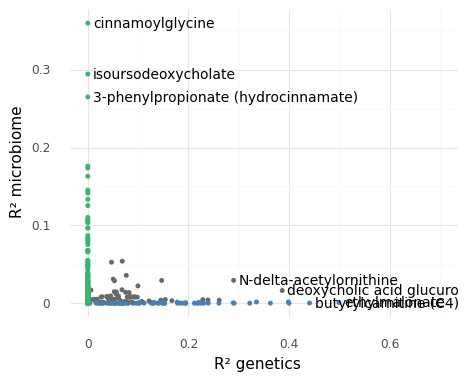

<ggplot: (8762202458381)>

In [10]:
from plotnine import *
from mizani.formatters import percent_format

pl = (
    ggplot(joint_r_sq, aes(x="geno_r2", y="micro_r2", color="group"))
    + geom_point(size=2, stroke=0)
    + geom_text(
        aes(label="BIOCHEMICAL_NAME"), 
        data=joint_r_sq[
            ((joint_r_sq.total > 0.3) & (joint_r_sq.group == "hybrid")) 
            | (joint_r_sq.micro_r2 > 0.25) 
            | (joint_r_sq.geno_r2 > 0.42)], 
        ha="left", nudge_x=0.01, size=10, color="black")
    + theme_minimal()
    + theme(figure_size=(5,4))
    + xlim(0, 0.7)
    + scale_color_manual(values={"genetics": "steelblue", "microbiome": "mediumseagreen", "hybrid": "dimgray"})
    + labs(x="R² genetics", y="R² microbiome") + guides(color=None)
)
pl.save("figures/valid_r2.pdf", width=6, height=4)
pl

And we can also look at the most prevalent metabolites.

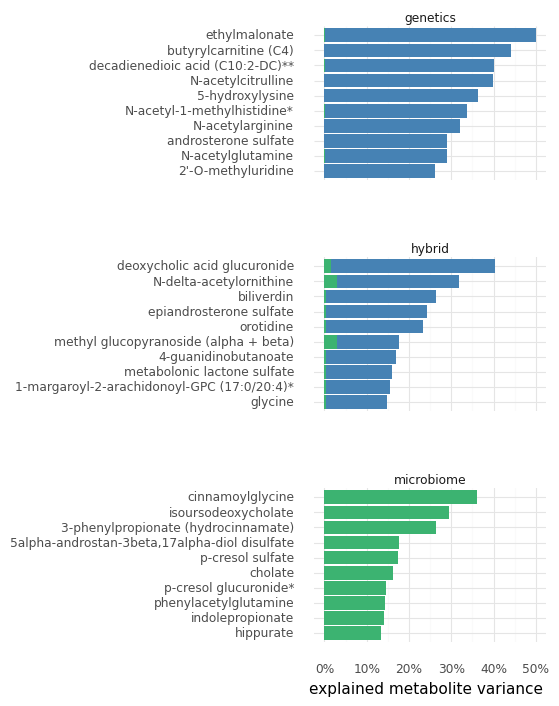

<ggplot: (8762258596976)>

In [11]:
pl = (
    ggplot(long[(long.r2 > 0.0) & (long.metabolite.isin(top))].sort_values(by="r2"), aes(y="r2", x="BIOCHEMICAL_NAME", fill="type"))
    + geom_bar(stat="identity") 
    + scale_y_continuous(labels=percent_format())
    + coord_flip()
    + facet_wrap("~ group", scales="free_y", ncol=1)
    + labs(y = "explained metabolite variance", x="")
    + scale_fill_manual(values=["steelblue", "mediumseagreen"])
    + guides(fill = None)
    + theme_minimal() 
    + theme(figure_size=(3, 8), subplots_adjust={"hspace": 0.5})
)
pl.save("figures/valid_specific_r2.pdf", width=3, height=6)
pl

And we can ask what fractions of metabolites fall into each group.

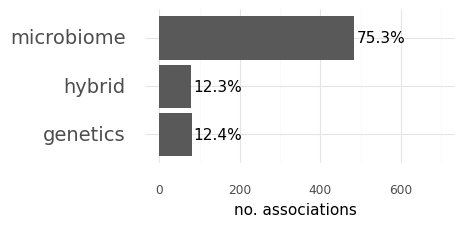

<ggplot: (8762200953597)>

In [12]:
pl = (
    ggplot(joint_r_sq, aes(x="group"))
    + geom_bar() 
    + theme_minimal()
    + theme(figure_size=(4, 2), axis_text_y = element_text(size=14))
    + ylim(0, 700)
    + labs(x="", y="no. associations")
    + geom_text(
     aes(label=after_stat('prop*100'), group=1),
     stat='count',
     nudge_y=5.0,
     va='center',
     ha="left",
     format_string='{:.1f}%'
     )
    + coord_flip()
  
)
pl.save("figures/valid_type_fractions.pdf", width=4, height=2)
pl

## Feature overlap

An additional check we can run is whether the genetic and microbiome variance components have any overlap. For that we run joined models for all hybrid metabolites and will track the variance explained by the joint model as well.

In [13]:
hybrids = joint_r_sq.metabolite[joint_r_sq.group == "hybrid"]

combined_r2 = []
combined_fits = pickle.load(open("data/train_combined_fits.pkl", "rb"))
for met in track(hybrids):
    snps = sig_snps.SNP[sig_snps.metabolite == met] #.str.split(";").str[0]
    snp_terms = ["Q('%s')" % s for s in snps]
    geno = pd.DataFrame({s: genotypes.get_geno_marker(s) for s in snps}, index=genome_ids)
    mics = sig_microbes.taxon[sig_microbes.metabolite == met]
    mterms = ["Q('%s')" % m for m in mics]
    df = pd.merge(metabolites[["genome_id", "stool_sample_id", met]], geno, left_on="genome_id", right_index=True)
    df = pd.merge(df, metabolites_and_microbes[["stool_sample_id"] + mics.to_list()], on="stool_sample_id")
    mets = df[met]
    predicted = combined_fits[met].predict(df)
    fit = smf.ols("mets ~ predicted", data=pd.DataFrame({"mets": mets, "predicted": predicted})).fit()
    predicted = fit.predict(pd.DataFrame({"mets": mets, "predicted": predicted}))
    metrics = pd.DataFrame({
        "metabolite": met,
        "n_taxa": len(mics),
        "combined_r2": 1.0 - (mets - predicted).var()/mets.var()
    }, index=[met])
    combined_r2.append(metrics)
    combined_fits[met] = fit
combined_r2 = pd.concat(combined_r2)

Output()

In [14]:
combined_r2 = pd.merge(combined_r2, joint_r_sq.reset_index(drop=True), on="metabolite")
combined_r2

,metabolite,n_taxa_x,combined_r2,n_taxa_y,micro_r2,geno_r2,CHEMICAL_ID,BIOCHEMICAL_NAME,SUPER_PATHWAY,SUB_PATHWAY,CAS,KEGG,total,group
0,metabolite_100020550,16,0.432758,16.0,0.016300,0.386310,100020550,deoxycholic acid glucuronide,Lipid,Secondary Bile Acid Metabolism,NaN,NaN,0.402610,hybrid
1,metabolite_100004523,10,0.310492,10.0,0.029381,0.289698,100004523,N-delta-acetylornithine,Amino Acid,Urea cycle; Arginine and Proline Metabolism,NaN,NaN,0.319079,hybrid
2,metabolite_250,3,0.257940,3.0,0.003665,0.261119,250,biliverdin,Cofactors and Vitamins,Hemoglobin and Porphyrin Metabolism,55482-27-4;55482-27-4,C00500,0.264785,hybrid
3,metabolite_100001287,5,0.244246,5.0,0.004131,0.238849,100001287,epiandrosterone sulfate,Lipid,Steroid,22229-22-7,C07635,0.242980,hybrid
4,metabolite_100001416,1,0.230483,1.0,0.004549,0.228514,100001416,orotidine,Nucleotide,"Pyrimidine Metabolism, Orotate containing",314-50-1,C01103,0.233063,hybrid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,metabolite_100009219,6,0.000533,6.0,0.005307,0.002576,100009219,1-oleoyl-2-arachidonoyl-GPE (18:1/20:4)*,NaN,NaN,NaN,NaN,0.007884,hybrid
75,metabolite_572,1,0.003124,1.0,0.002934,0.001426,572,glucose,Carbohydrate,"Glycolysis, Gluconeogenesis, and Pyruvate Meta...",50-99-7,C00031,0.004360,hybrid
76,metabolite_100021131,1,0.001086,1.0,0.002332,0.000535,100021131,undecenoylcarnitine (C11:1),Lipid,"Fatty Acid Metabolism (Acyl Carnitine, Monouns...",NaN,NaN,0.002867,hybrid
77,metabolite_461,1,0.002487,1.0,0.000120,0.002366,461,phosphate,Energy,Oxidative Phosphorylation,7664-38-2,C00009,0.002486,hybrid


In [15]:
combined_r2['additive_tick_loc'] = combined_r2.index.values*2 + 0.375
combined_r2['joint_tick_loc'] = combined_r2.index.values*2 + 1.125
combined_r2['lable_tick_loc'] = combined_r2.index.values*2 + 0.75

And let's visualize the difference between the joint and individual models.

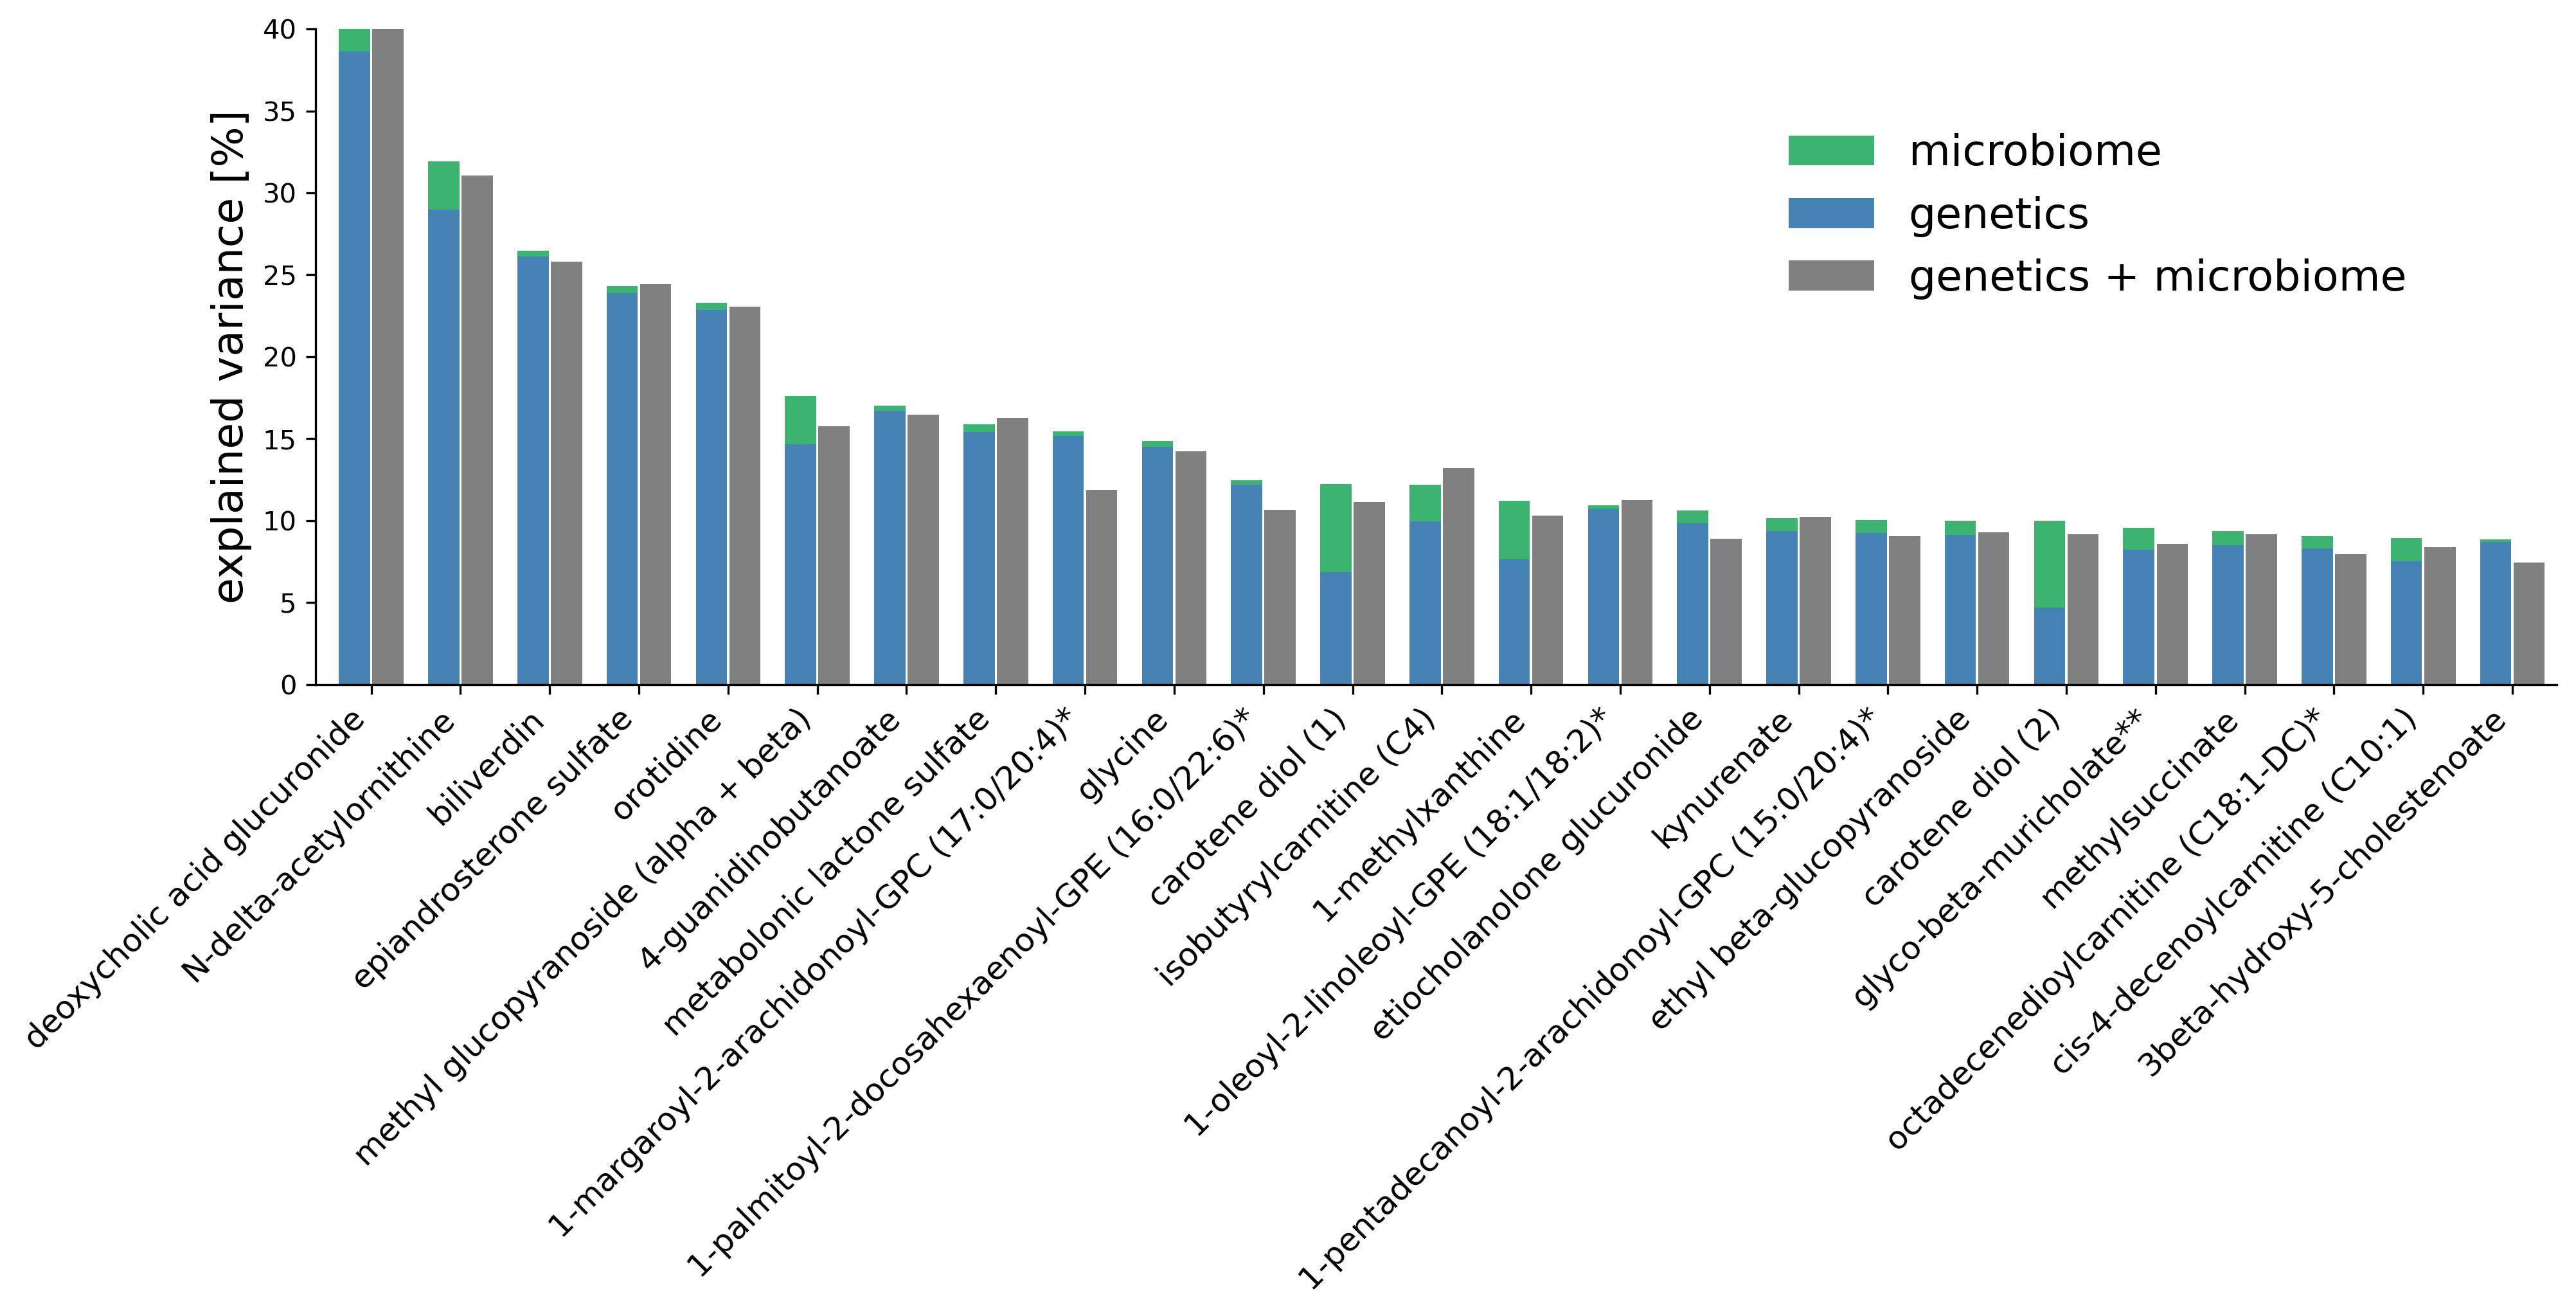

In [16]:
import matplotlib.pyplot as plt
import numpy
import seaborn as sns

cutoff = 25
range_max = int(numpy.round(combined_r2['combined_r2'].max(), 1) * 100)

joint_subset = combined_r2.iloc[:cutoff,:]

fig = plt.figure(figsize=(15, 4.5), dpi = 300)
ax = plt.subplot()
ax.bar(joint_subset["additive_tick_loc"], joint_subset["total"], width=0.7,
            label="microbiome", color="mediumseagreen")
ax.bar(joint_subset["additive_tick_loc"], joint_subset["geno_r2"],width=0.7,
            label="genetics", color="steelblue")
ax.bar(joint_subset["joint_tick_loc"], joint_subset["combined_r2"],width=0.7,
            label="genetics + microbiome", color="grey")
sns.despine()
ax.set_ylim([0,range_max/100])
ax.set_xlim([-0.5,max(joint_subset['lable_tick_loc'].values) + 1])
ax.set_yticklabels(list(range(0,range_max + 5,5)), fontdict={'size':10})
ax.set_xticks((joint_subset['lable_tick_loc'].values))
ax.set_xticklabels(joint_subset['BIOCHEMICAL_NAME'], fontdict={'size':12}, rotation = 45, ha = 'right')
ax.set_ylabel('explained variance [%]', fontdict={'size':16})
ax.set_xlabel('')
ax.legend(bbox_to_anchor = (0.95, 0.9), frameon=False, prop={'size': 16})
plt.savefig("figures/valid_hybrid_r2.pdf", pad_inches=0.1, bbox_inches="tight")
plt.show()
plt.close()

And we can look for significant overlap.

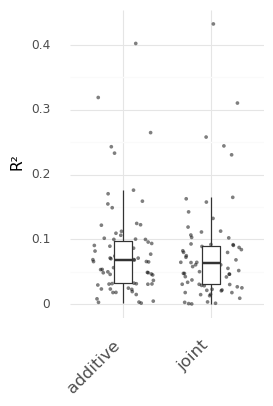

<ggplot: (8762200292615)>

In [17]:
model_comp = combined_r2[["BIOCHEMICAL_NAME", "total", "combined_r2"]].rename(columns={"total": "additive", "combined_r2": "joint"}).melt(id_vars="BIOCHEMICAL_NAME", var_name="type", value_name="r2")
pl = (
    ggplot(model_comp, aes(x="type", y="r2"))
    + geom_jitter(height=0, width=0.35, alpha=0.5, stroke=0)
    + geom_boxplot(width=0.2, outlier_color="none")
    + theme_minimal()
    + labs(x="", y="R²")
    + theme(figure_size=(2.5, 4), axis_text_x = element_text(angle=45, ha="right", va="top", size=12))
)
pl.save("figures/valid_r2_overlap.pdf", width=2.5, height=4)
pl

In [18]:
from scipy.stats import wilcoxon

print((combined_r2.total - combined_r2.combined_r2).describe())
wilcoxon(combined_r2.total, combined_r2.combined_r2)

count    79.000000
mean      0.004984
std       0.008514
min      -0.030148
25%       0.000456
50%       0.003403
75%       0.008233
max       0.037097
dtype: float64


WilcoxonResult(statistic=358.0, pvalue=2.3436398531835394e-09)